In [1]:

import numpy as np
import matplotlib.pyplot as plt
# If you need to import from a local utils.py, uncomment and adjust the following lines:
import sys
import os
import jax.numpy as jnp
# Construct the full path to the folder
folder_path = r'C:\Users\Petrb\Desktop\DTU\3rdSemester\02477_BAYESIAN_MACHINE_LEARNING'

# Add the folder to the Python path
sys.path.append(folder_path)

# Now you can import the utils module
from EXAMS.EXAM_2024.Task_2.utils import *

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
from kernel_gaussian_classes import * 

## Part 2: Gaussian process regression

Let $\mathcal{D} = \{(x_n, y_n)\}_{n=1}^{N}$ be a dataset for regression, where $x_n \in \mathbb{R}$ and $y_n \in \mathbb{R}$ are the input and output for the $n$'th observation, respectively:

$$
\mathbf{x} = \begin{bmatrix} -2.00 & 0.00 & 2.00 \end{bmatrix}, \quad
\mathbf{y} = \begin{bmatrix} -2.01 & 1.41 & 0.23 \end{bmatrix},
$$

such that $x_n$ and $y_n$ are the $n$'th elements in $\mathbf{x}$ and $\mathbf{y}$, respectively, for $N = 3$.

Assume a Gaussian process regression model of the form

$$
y_n = f(x_n) + \epsilon_n,
$$

where $f \sim \mathcal{GP}(0, k_1(x, x'))$ and $\epsilon_n \sim \mathcal{N}(0, \sigma^2)$ is i.i.d additive Gaussian noise. Assume the following **squared exponential kernel**:

$$
k_1(x, x') = 2 \exp\left(-\frac{1}{8} \|x - x'\|_2^2\right)
$$

and assume the standard deviation of the noise is given by $\sigma = \frac{1}{2}$.

---

### Question 2.1

Determine the value of the magnitude and lengthscale hyperparameters for the kernel $k_1$ in eq. (7).


The squared exponential kernel is given by:
$k(x, x') = \kappa^2 \exp\left(-\frac{1}{2l^2} \|x - x'\|_2^2\right)$
where $\kappa^2$ is the magnitude and $l$ is the lengthscale hyperparameter.

We see, that kappa = $\sqrt{2}$ and $l = 2$.



### 1. Extract the kernel hyper-parameters  
The squared–exponential kernel in the hand-out is  

$$
k_1(x,x') \;=\; 2\;\exp\!\Bigl(-\frac{1}{8}\,\lVert x-x'\rVert_2^{\,2}\Bigr).
$$

The standard S.E. form is  

$$
k_{\text{SE}}(x,x') \;=\; \sigma_f^{2}\,
\exp\!\Bigl(-\frac{\lVert x-x'\rVert_2^{\,2}}{2\ell^{2}}\Bigr).
$$

Equating exponents gives  

$$\frac{1}{2\ell^{2}} = \frac{1}{8}\quad\Longrightarrow\quad
\ell = 2,$$  

and the prefactor tells us  

$\sigma_f^{2} = 2.$

Hence  

* **magnitude** (signal variance): $\sigma_f^{2}=2,$  
* **length-scale**: $\ell=2.$


__________________________

In [9]:
x = jnp.array([-2.00, 0.00, 2.00])[:, None]
y = jnp.array([-2.01, 1.41, 0.23])[:, None]



Let $\mathbf{f} \in \mathbb{R}^N$ denote a vector containing the values of the function $f$ evaluated at the training points, i.e.
$$
\mathbf{f} = \begin{bmatrix} f(x_1) & f(x_2) & \cdots & f(x_N) \end{bmatrix}^\top.
$$


### Question 2.2

Determine the analytical prior distribution $p(\mathbf{f}|\mathbf{x})$.


---

### 2. Assemble the kernel (covariance) matrix  
Training inputs  

$$
\mathbf x = [-2,\, 0,\, 2]^{\!\top},\qquad N=3.
$$

Compute every entry $$K_{ij}=k_1(x_i,x_j):$$  

| $x_i$ | $x_j$ | $\lVert x_i-x_j\rVert^{2}$ | $k_1(x_i,x_j)$ |
|-------|-------|----------------------------|----------------|
| $-2$  | $-2$  | $0$  | $2$ |
| $-2$  | $0$   | $4$  | $2\exp(-\tfrac{1}{8}\!\times\!4)=2e^{-0.5}\approx 1.2131$ |
| $-2$  | $2$   | $16$ | $2\exp(-\tfrac{1}{8}\!\times\!16)=2e^{-2}\approx 0.2707$ |
| $0$   | $0$   | $0$  | $2$ |
| $0$   | $2$   | $4$  | $1.2131$ |
| $2$   | $2$   | $0$  | $2$ |

Putting these into a matrix (symmetric by construction)

$$
K =
\begin{bmatrix}
2 & 1.2131 & 0.2707 \\
1.2131 & 2 & 1.2131 \\
0.2707 & 1.2131 & 2
\end{bmatrix}.
$$

---

### 3. Write down the GP prior  
For a Gaussian process $$f\sim\mathcal{GP}\!\bigl(0,k_1\bigr)$$, the finite-dimensional prior over  
$$\mathbf f = [\,f(x_1),\,f(x_2),\,f(x_3)\,]^{\!\top}$$  
is multivariate normal:

$$
p(\mathbf f\mid\mathbf x)
      \;=\;
\mathcal N\!\bigl(\mathbf f \,\bigl|\, \mathbf 0,\; K \bigr).
$$

That’s “the value of the prior” you need: zero mean and the covariance matrix $$K$$ we just calculated.

---

### 4. Quick check: prior variance at each training point  
Because $$\operatorname{Var}\bigl[f(x_i)\bigr] = K_{ii},$$ every training point here has prior variance $$2.$$

*(If you were instead asked for the prior variance under the **second** kernel $$k_2(x,x')=\exp(-\tfrac12\lVert x-x'\rVert_2)+2,$$ you would evaluate $$k_2(x,x)=1+2=3,$$ i.e.\ the prior variance is $$3$$ everywhere.)*



In [12]:

kappa = jnp.sqrt(2)
ell = 2.0
sigma = 0.5 


kernel = StationaryIsotropicKernel(kappa=kappa, lengthscale=ell, kernel_fun=squared_exponential)

K_prior = kernel.contruct_kernel(x, x)

print('Prior mean\n', np.zeros(len(x)), '\n')
print('Prior covariance\n', np.array2string(K_prior, precision=2))

Prior mean
 [0. 0. 0.] 

Prior covariance
 [[2.   1.21 0.27]
 [1.21 2.   1.21]
 [0.27 1.21 2.  ]]


____________________
### Question 2.3

Determine the analytical posterior distribution $p(\mathbf{f}|\mathbf{y}, \mathbf{x})$.


---

In [5]:
kernel = StationaryIsotropicKernel(kappa=kappa, lengthscale=ell, kernel_fun=squared_exponential)

model = GaussianProcessRegression(x, y, kernel=kernel, sigma=sigma, kappa=kappa, lengthscale=ell)

In [13]:
mu, var = model.predict_f(x)
print('Posterior mean\n', np.array2string(mu, precision=2), '\n')
print('Posterior covariance\n', np.array2string(var, precision=2), '\n')

Posterior mean
 [[-1.53]
 [ 0.89]
 [ 0.43]] 

Posterior covariance
 [[ 0.21  0.03 -0.01]
 [ 0.03  0.19  0.03]
 [-0.01  0.03  0.21]] 



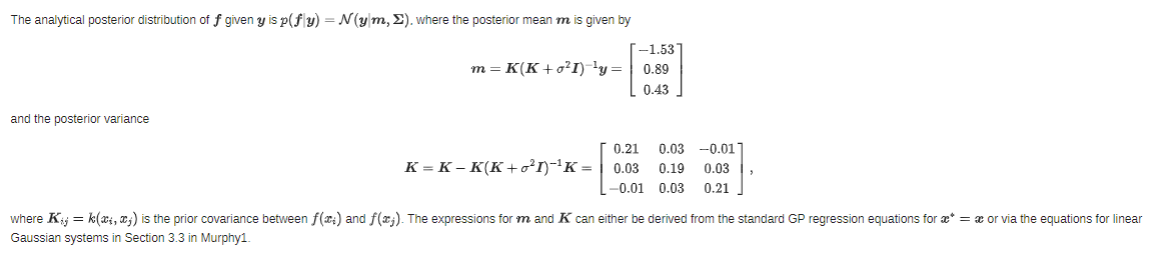

In [7]:
def rbf(X1, X2, length_scale=1.0, kappa=1.0, debug=False):
    """
    Computes a “squared exponential style” kernel (here using an L₁ based form) plus a linear term.
    
    Parameters
    ----------
    X1 : np.ndarray, shape (n1, d)
        First batch of points (n1 points in d dimensions).
    X2 : np.ndarray, shape (n2, d)
        Second batch of points (n2 points in d dimensions).
    length_scale : float
        Lengthscale parameter ell > 0 (default 1.0).
    variance : float
        Variance (amplitude) parameter σ² (default 1.0).  Currently not used in your return statement,
        but you could multiply the whole kernel by this if desired.
    
    Returns
    -------
    K : np.ndarray, shape (n1, n2)
        Kernel matrix where
          K[i,j] = 1 * (1 + (‖X1[i] − X2[j]‖₁ / (2 ℓ²)))⁻¹  +  X1[i] · X2[j]
    """
    # ensure length_scale is positive and nonzero
    l = np.abs(length_scale) + 1e-12
    

    
    # 2) Compute pairwise differences via broadcasting:
    #    diff[i,j,k] = X1[i,k] - X2[j,k]
    #    shape of diff: (n1, n2, d)
    diff = X1[:, None, :] - X2[None, :, :]
    
    # 3) Sum absolute differences over the last axis to get L1 distance:
    #    sqdist[i,j] = sum_k |diff[i,j,k]|
    #    shape of sqdist: (n1, n2)*
    sqdist = np.linalg.norm((diff)**2, axis=2)
    
    
    # 4) Compute the kernel:
    #    A) “Squared‐exponential–style” term (but using L1 distance here):
    #         (1 + sqdist / (2 ℓ²))⁻¹
    #    B) Plus a linear term X1·X2ᵀ
    #    Final shape: (n1, n2)
    
    
    if debug:
        print("*" * 50)
        print("Debugging information:")
        
        print("Length scale (l):", l)
        # 1) Print shapes for debugging
        #   X1 shape: (n1, d)
        print("X1 shape before:", X1.shape)
        #   After adding a new axis: (n1, 1, d)
        print("X1[:, None, :] shape:", X1[:, None, :].shape)
        #   X2 shape: (n2, d)
        print("X2 shape before:", X2.shape)
        #   After adding a new axis: (1, n2, d)
        print("X2[None, :, :] shape:", X2[None, :, :].shape)
        #  diff shape: (n1, n2, d)
        print("diff shape:", diff.shape)
        #  sqdist shape: (n1, n2)
        print("sqdist shape:", sqdist.shape)
        #  K shape: (n1, n2)
        print("K shape:", np.exp(-0.5 * sqdist ) + 2 .shape)
        # print K 
        print("K:", np.exp(-0.5 * sqdist ) + 2 )
        print("*" * 50)
        print("*" * 50)
    
    return np.exp(-0.5 * sqdist ) + 2 

In [8]:
xstar = np.array([[2.0]])

C = rbf(xstar, xstar)

print("prior mean m(x*): 0.0 (assumed)")
print("prior variance C  :\n", C)

prior mean m(x*): 0.0 (assumed)
prior variance C  :
 [[3.]]


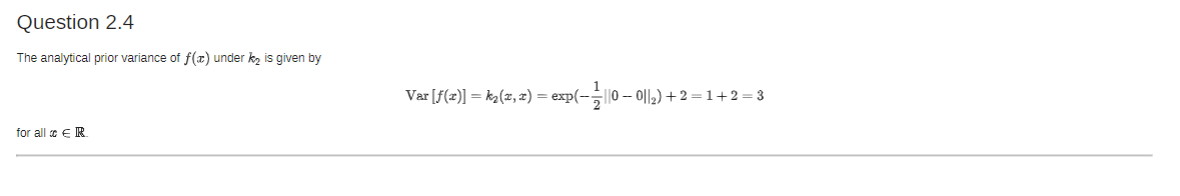